<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2022TeamA/blob/main/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
reset -f


**Import der Libraries und Verbindung mit Google Drive und Sqlite3**

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def connect_to_db(db_file):
    sqlite3_conn = None
    try:
        sqlite3_conn = sq.connect(db_file)
        return sqlite3_conn

    except Error as err:
        print(err)

        if sqlite3_conn is not None:
            sqlite3_conn.close()
  
conn_dwh = sqlite3.connect('/content/drive/Shareddrives/Gruppe A/Datawarehouse.db')


**Erstellen eines Ursprungsdataframes aus dem Datawarehouse**




In [4]:
df = pd.read_sql_query("""
select t1.*, dimObservations.id as OBSERVATION_ID, dimObservations.code, dimObservations.description, dimObservations.value, dimObservations.units, dimObservations.date from dimObservations
left JOIN
(select Zentrum.observation_id, Zentrum.patient_id, dimPatients.dataset_origin from Zentrum, dimPatients where Zentrum.patient_id = dimPatients.id) t1
on dimObservations.id = t1.observation_id
;""", conn_dwh
  )

In [5]:
df.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE
0,5,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,allergy,5,8462-4,Diastolic Blood Pressure,82.0,mm[Hg],2011-04-11T11:40:19Z
1,6,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,allergy,6,8480-6,Systolic Blood Pressure,110.0,mm[Hg],2011-04-11T11:40:19Z
2,7,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,allergy,7,8867-4,Heart rate,65.0,/min,2011-04-11T11:40:19Z


In [6]:
#Entfernen von Duplikaten
df.drop_duplicates(keep="first",inplace=True) 
print("Size of dataset after removing duplicated rows", df.shape)

Size of dataset after removinf duplicated rows (35414, 9)


In [7]:
# Übersicht 
df.nunique(axis=0)

observation_id    35414
patient_id         1051
dataset_origin        3
OBSERVATION_ID    35414
CODE                 13
DESCRIPTION          14
VALUE              1903
UNITS                 8
DATE               5773
dtype: int64

In [8]:
#Ursprung der Daten
df.groupby(["dataset_origin"]).size()

dataset_origin
allergy              10544
colorectal_cancer      372
covid19              24498
dtype: int64

**Erstellen eines Dataframes, der nur Angaben zu COVID-positiven Patienten enthält. Diese werden in einer zusätzlichen Spalte mit "1" bezeichnet**





In [9]:
#Zunächst Selektion der positiven Testergebnisse
dfpostest = df.loc[(df["CODE"] == "94531-1") & (df["VALUE"] == "Detected (qualifier value)")] 
dfpostest.head(3)



,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE
52,140,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,allergy,140,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,2020-03-10T12:31:19Z
291,900,aff157cc-b6d3-412b-ccbe-bfd5fac1c2d5,allergy,900,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,2020-03-07T02:02:18Z
343,1061,28124841-1cf3-2818-d4ee-8574fac23298,allergy,1061,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,2020-02-28T00:30:05Z
1627,1377,27b0d72c-f2fb-7e25-38c0-7d5120ebbedf,allergy,1377,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,2020-03-06T15:56:44Z
1679,1511,bdf7af8e-c765-1e02-dc9d-24b49ad290a3,allergy,1511,94531-1,SARS-CoV-2 RNA Pnl Resp NAA+probe,Detected (qualifier value),None,2020-03-10T19:32:13Z


In [11]:
# Erstellen eines Dataframes mit allen Laborwerten der Patienten mit positivem Testergebnis
dfpos = df.loc[((df.patient_id.isin(dfpostest['patient_id'])))]


In [12]:
# Löschen der Patienten mit COVID-Nebendiagnse aus dem ALLERGY-Dataset, da diese zahlreiche nicht mit der COVID-Infektion im Zusammenhang stehende (ältere) Laborparameter haben
dfpos = dfpos.drop( dfpos[ dfpos['dataset_origin'] == "allergy" ].index)

In [13]:
# Hinzufügen einer zusätzlichen Spalte mit dem Wert "1"
dfpos['Covid'] = '1'
dfpos.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE,Covid
47886,143480,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143480,8310-5,Body temperature,41.4,Cel,2020-02-17T21:57:21Z,1
47888,143481,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143481,9279-1,Respiratory rate,21.4,/min,2020-02-17T21:57:21Z,1
47890,143482,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143482,8867-4,Heart rate,61.6,/min,2020-02-17T21:57:21Z,1
47892,143484,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143484,8462-4,Diastolic Blood Pressure,85.0,mm[Hg],2020-02-17T21:57:21Z,1
47894,143485,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143485,8480-6,Systolic Blood Pressure,117.0,mm[Hg],2020-02-17T21:57:21Z,1


In [14]:
#Übersicht der Covid-Kohorte
dfpos.nunique(axis=0)

observation_id    24258
patient_id          865
dataset_origin        1
OBSERVATION_ID    24258
CODE                 13
DESCRIPTION          13
VALUE              1861
UNITS                 7
DATE               3481
Covid                 1
dtype: int64

**Erstellen eines Dataframes, der nur die Patienten der Kontrollgruppe beinhaltet. Diese werden in einer zusätzlichen Spalte mit "0" bezeichnet**

In [15]:
#Selektion der Laborparameter von Patienten ohne positiven COVID-Test aus dem Ursprungsdataframe
dfneg = df.loc[~((df.patient_id.isin(dfpostest['patient_id'])))]
dfneg.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE
70,192,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,192,8462-4,Diastolic Blood Pressure,78.0,mm[Hg],2011-06-12T16:56:37Z
71,193,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,193,8480-6,Systolic Blood Pressure,115.0,mm[Hg],2011-06-12T16:56:37Z
72,194,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,194,8867-4,Heart rate,77.0,/min,2011-06-12T16:56:37Z
73,195,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,195,9279-1,Respiratory rate,14.0,/min,2011-06-12T16:56:37Z
74,212,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,allergy,212,8462-4,Diastolic Blood Pressure,73.0,mm[Hg],2012-06-17T16:56:37Z


In [16]:
dfneg.shape

(5361, 9)

In [17]:
# Erstellen eines Dataframes von Patienten mit der Nebendiagnose Covid19 bzw. Verdacht auf Covid19
dfNebendiag = pd.read_sql_query("""
select patient_id, CODE, DESCRIPTION from dimConditions where code in ("840544004","840539006")
;""", conn_dwh
  )


In [18]:
dfNebendiag.head(3)

,PATIENT_ID,CODE,DESCRIPTION
0,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,840544004,Suspected COVID-19
1,3575b903-dbd0-1d55-6146-9e8aa4ed52a5,840539006,COVID-19
2,17f0c6d9-8931-8839-66cb-3ca6fb066d3e,840544004,Suspected COVID-19
3,aff157cc-b6d3-412b-ccbe-bfd5fac1c2d5,840544004,Suspected COVID-19
4,aff157cc-b6d3-412b-ccbe-bfd5fac1c2d5,840539006,COVID-19


In [19]:
# Um Sicherzugehen, dass wirklich nur Covid-neg. Patienten in der Kontrollgruppe sind werden auch Patienten ohne Testergebnis aber mit Nebendiagnose Covid19 bzw. Verdacht auf Covid19 ausgeschlossen.
dfneg = dfneg.loc[~((dfneg.patient_id.isin(dfNebendiag["PATIENT_ID"])))]


In [20]:
# Hinzufügen Spalte mit Wert "0"
dfneg['Covid'] = '0'
dfneg.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE,Covid
123,377,e92765c7-1c4b-9ee7-dbc8-5300fcb40a54,allergy,377,8462-4,Diastolic Blood Pressure,86.0,mm[Hg],2010-11-21T07:31:12Z,0
124,378,e92765c7-1c4b-9ee7-dbc8-5300fcb40a54,allergy,378,8480-6,Systolic Blood Pressure,117.0,mm[Hg],2010-11-21T07:31:12Z,0
125,379,e92765c7-1c4b-9ee7-dbc8-5300fcb40a54,allergy,379,8867-4,Heart rate,68.0,/min,2010-11-21T07:31:12Z,0


In [21]:
dfneg.shape

(4985, 10)

In [22]:
#Übersicht Kontrolgruppe
dfneg.nunique(axis=0)

observation_id    4985
patient_id          56
dataset_origin       2
OBSERVATION_ID    4985
CODE                12
DESCRIPTION         13
VALUE              910
UNITS                8
DATE               942
Covid                1
dtype: int64

**Zusammenfügen von COVID-pos. Kohorte und Kontrollgruppe in einen Dataframe**

In [23]:
dffinal = pd.concat([dfpos, dfneg])
dffinal.head(3)

,observation_id,patient_id,dataset_origin,OBSERVATION_ID,CODE,DESCRIPTION,VALUE,UNITS,DATE,Covid
47886,143480,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143480,8310-5,Body temperature,41.4,Cel,2020-02-17T21:57:21Z,1
47888,143481,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143481,9279-1,Respiratory rate,21.4,/min,2020-02-17T21:57:21Z,1
47890,143482,ad5525c0-fdab-94dc-018f-d7209c72bdef,covid19,143482,8867-4,Heart rate,61.6,/min,2020-02-17T21:57:21Z,1


**Vergleichende Analyse der Laborparameter zwischen den Gruppen**

In [26]:
#Auswählen des Laborparameters GFR
gfr = dffinal[dffinal['CODE'] == "33914-3"]
# Konvertieren der Laborwerte und des Covid-Status in Zahlenwerte (Floats)
gfr['VALUE'] = gfr['VALUE'].astype(float)
gfr['Covid'] = gfr['Covid'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


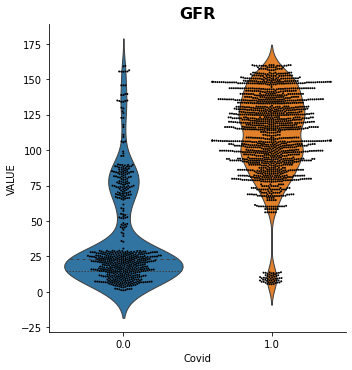

In [27]:
g = sns.catplot(data=gfr, x="Covid", y="VALUE", kind="violin", inner="quart", linewidth=1)
sns.swarmplot(data=gfr, x="Covid", y="VALUE", color="k", size=2, ax=g.ax)
plt.title('GFR', weight='bold').set_fontsize('16')